In [14]:
import os
from typing import Literal
from pydantic import BaseModel, Field

# Core imports matching the tutorial
from langchain_chroma import Chroma
from langchain_ollama import OllamaEmbeddings, ChatOllama
from langchain_core.tools import tool
from langchain_core.messages import convert_to_messages
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain.agents.tool_node import ToolNode, tools_condition

from dotenv import load_dotenv
load_dotenv('./../.env')


True

In [ ]:
# ============================================================================
# STEP 1: CONNECT TO EXISTING VECTOR STORE
# ============================================================================
print("Connecting to existing Chroma vector store...")

# Use the same embeddings as your ingestion code
embeddings = OllamaEmbeddings(
    model="nomic-embed-text",
    base_url="http://localhost:11434"
)

# Chroma Vector Store (assumes data already exists from previous code)
vector_store = Chroma(
    collection_name="pdf_collection",
    embedding_function=embeddings,
    persist_directory="..\\01 Semantic Search\\chroma_db"
)

print("✓ Connected to existing vector store")


Connecting to existing Chroma vector store...
✓ Connected to existing vector store


In [ ]:
# ============================================================================
# STEP 2: CREATE RETRIEVER TOOL
# ============================================================================
@tool
def retrieve_documents(query: str):
    """Search and return information from the PDF documents in the database."""
    print(f"🔍 Searching: '{query}'")
    
    # Perform similarity search using the retriever
    docs = vector_store.similarity_search(query,k=4)
    
    # Format results for the LLM
    if docs:
        content = "\n\n".join(
            f"Page {doc.metadata.get('page', '?')}: {doc.page_content}" 
            for doc in docs
        )
        print(f"✓ Found {len(docs)} relevant chunks")
        return content
    else:
        print("✗ No relevant documents found")
        return "No relevant information found."

retriever_tool = retrieve_documents

print("✓ Created retriever tool")

✓ Created retriever tool


In [4]:
# ============================================================================
# STEP 3: INITIALIZE MODELS
# ============================================================================
# Using ChatOllama instead of OpenAI
response_model = ChatOllama(
    model="qwen3", 
    base_url="http://localhost:11434",
    temperature=0
)
grader_model = ChatOllama(
    model="qwen3", 
    base_url="http://localhost:11434",
    temperature=0
)

print("✓ Initialized chat models")


✓ Initialized chat models


In [5]:
# ============================================================================
# STEP 4: NODE FUNCTIONS (from tutorial)
# ============================================================================

def generate_query_or_respond(state: MessagesState):
    """Call the model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply respond to the user.
    """
    response = (
        response_model
        .bind_tools([retriever_tool]).invoke(state["messages"])  
    )
    return {"messages": [response]}

In [6]:
# Document grading
GRADE_PROMPT = (
    "You are a grader assessing relevance of a retrieved document to a user question. \n "
    "Here is the retrieved document: \n\n {context} \n\n"
    "Here is the user question: {question} \n"
    "If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n"
    "Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."
)

class GradeDocuments(BaseModel):  
    """Grade documents using a binary score for relevance check."""
    binary_score: str = Field(
        description="Relevance score: 'yes' if relevant, or 'no' if not relevant"
    )

def grade_documents(
    state: MessagesState,
) -> Literal["generate_answer", "rewrite_question"]:
    """Determine whether the retrieved documents are relevant to the question."""
    question = state["messages"][0].content
    context = state["messages"][-1].content

    prompt = GRADE_PROMPT.format(question=question, context=context)
    response = (
        grader_model
        .with_structured_output(GradeDocuments).invoke(  
            [{"role": "user", "content": prompt}]
        )
    )
    score = response.binary_score

    if score == "yes":
        return "generate_answer"
    else:
        return "rewrite_question"

In [7]:
# Question rewriting
REWRITE_PROMPT = (
    "Look at the input and try to reason about the underlying semantic intent / meaning.\n"
    "Here is the initial question:"
    "\n ------- \n"
    "{question}"
    "\n ------- \n"
    "Formulate an improved question:"
)

def rewrite_question(state: MessagesState):
    """Rewrite the original user question."""
    messages = state["messages"]
    question = messages[0].content
    prompt = REWRITE_PROMPT.format(question=question)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [{"role": "user", "content": response.content}]}


In [8]:
# Answer generation
GENERATE_PROMPT = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer the question. "
    "If you don't know the answer, just say that you don't know. "
    "Use three sentences maximum and keep the answer concise.\n"
    "Question: {question} \n"
    "Context: {context}"
)

def generate_answer(state: MessagesState):
    """Generate an answer."""
    question = state["messages"][0].content
    context = state["messages"][-1].content
    prompt = GENERATE_PROMPT.format(question=question, context=context)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [response]}

print("✓ Defined all node functions")


✓ Defined all node functions


In [9]:
# ============================================================================
# STEP 5: ASSEMBLE THE GRAPH
# ============================================================================
workflow = StateGraph(MessagesState)

# Define the nodes we will cycle between
workflow.add_node(generate_query_or_respond)
workflow.add_node("retrieve", ToolNode([retriever_tool]))
workflow.add_node(rewrite_question)
workflow.add_node(generate_answer)

workflow.add_edge(START, "generate_query_or_respond")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "generate_query_or_respond",
    # Assess LLM decision (call `retriever_tool` tool or respond to the user)
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate_answer", END)
workflow.add_edge("rewrite_question", "generate_query_or_respond")

# Compile
graph = workflow.compile()

print("✓ Assembled and compiled the graph")


✓ Assembled and compiled the graph


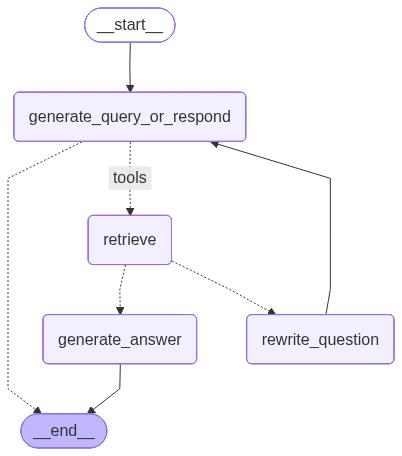

In [13]:
graph

In [10]:
# ============================================================================
# STEP 6: TEST THE AGENTIC RAG
# ============================================================================
def run_agentic_rag(question: str):
    """Run the agentic RAG system with a question"""
    print(f"\n{'='*60}")
    print(f"QUESTION: {question}")
    print(f"{'='*60}")
    
    for chunk in graph.stream(
        {
            "messages": [
                {
                    "role": "user",
                    "content": question,
                }
            ]
        }
    ):
        for node, update in chunk.items():
            print(f"\nUpdate from node: {node}")
            print("-" * 40)
            print(update["messages"][-1])
            print()

In [11]:
question = "What are the main methods mentioned in this paper?"
run_agentic_rag(question)



QUESTION: What are the main methods mentioned in this paper?

Update from node: generate_query_or_respond
----------------------------------------
content='<think>\nOkay, the user is asking about the main methods mentioned in a paper. But wait, the tools provided here are for retrieving documents from PDFs in a database. The function given is retrieve_documents, which takes a query parameter. However, the user\'s question is about a paper\'s methods, which implies they might be referring to a specific document they\'ve uploaded or that\'s in the database.\n\nWait, the problem is that the current tools don\'t have a function that can extract methods from a paper. The retrieve_documents function is for searching and returning information from PDFs, but the user is asking for specific content (methods) which might require a different function, like extract_methods or something similar. But according to the tools provided, such a function isn\'t available. \n\nHmm, maybe the user expects 

In [12]:
question = "Tell me about earth"
run_agentic_rag(question)


QUESTION: Tell me about earth

Update from node: generate_query_or_respond
----------------------------------------
content='<think>\nOkay, the user asked "Tell me about earth." I need to figure out how to respond. Let me check the tools available. There\'s a function called retrieve_documents that searches PDF documents in the database. The function requires a query parameter. Since the user is asking about Earth, I should use this function to get information from the documents. The query parameter should be "Earth" or "about Earth." Let me call the function with "Earth" as the query. That should retrieve the relevant information from the PDFs. I\'ll structure the tool call accordingly.\n</think>\n\n' additional_kwargs={} response_metadata={'model': 'qwen3', 'created_at': '2025-09-21T15:24:04.5412232Z', 'done': True, 'done_reason': 'stop', 'total_duration': 938370100, 'load_duration': 118749500, 'prompt_eval_count': 146, 'prompt_eval_duration': 21908400, 'eval_count': 138, 'eval_dura